In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import torch
import torch.nn as nn
import PIL
from typing import Tuple
import pandas as pd
from torchvision.transforms import ToTensor, Normalize, Compose
from IPython.display import clear_output
import torchvision.transforms as transforms
from torchvision.datasets.mnist import MNIST
from torch.utils.data import Dataset, DataLoader, random_split
from bounding_box import calculate_bounding_box
import matplotlib as mpl
from linear_model import LinearModel
from train_basic import simple_train
from iou import iou_metric
from train_improved import train_with_iou
from conf_1 import MLPModel_Configuration1
from conf_2 import MLPModel_Configuration2
from conf_3 import ConvModel
from conf_4 import Conv_Model_2
from plots import plot_metrics

mpl.rcParams['figure.dpi'] = 130

In [2]:
# First let´s create the Digits dataset reader. See the "bounding_box.py" for the implementation of the function

class Digits(Dataset):
    def __init__(self, root: str, train: bool = True, download: bool = True):
        super(Digits, self).__init__()
        
        self.mnist = MNIST(root=root, train=train, download=download)  # MNIST it´s in torchvision
        self.n = len(self.mnist)
        
    def __getitem__(self, idx: int) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """
        Returns the datapoint at index = idx.
        """
        
        im, label = self.mnist[idx]  # we are only interested on im
        
               
        transform = Compose([
              transforms.ToTensor(),
              Normalize(mean=(0.5,), std=(0.5,)), 

          ])
        
        return (transform(im), torch.as_tensor(calculate_bounding_box(im)))
        
    
    def __len__(self) -> int:
        """
        Returns the length of the dataset. Equals the length of the MNIST dataset.      
        """
        
        return self.n  # just return the length
        

In [3]:
full_train_dataset = Digits(root='../mnist', train=True)

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = Digits(root='../mnist', train=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../mnist/MNIST/raw



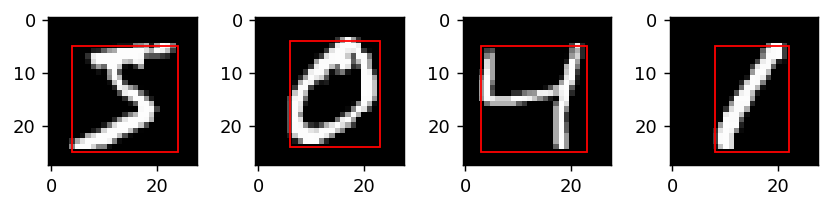

In [4]:
fig, ax = plt.subplots(1,4)  # let´s plot 4 numbers

fig.tight_layout(pad=0.2)  # to increase the space between the numbers

for i in range(0,4):
    
    image_data = full_train_dataset[i][0].squeeze().numpy() 
    ax[i].imshow(image_data, cmap="gray")

    x1, x2, y1, y2 = full_train_dataset[i][1]
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax[i].add_patch(rect)
    

## First, we will start with a simple linear model

In [5]:
input_size = 28*28
output_size = 4
lm = LinearModel(input_size, output_size)

Let´s define a simple train function for the linear model, using the MSE loss, which is reasonable for the task. In this case we will save the weights of the model that reaches the lowest loss. In this part we will only evaluate the model in the train dataset (despite it is not a good practice) because the model is simple and the next part a new train function will be implemented to deal with that.


In [6]:
simple_train(train_loader, lm, 5)

Epoch 1, loss: 1.0822386741638184
Epoch 2, loss: 1.2282434701919556
Epoch 3, loss: 1.5321990251541138
Epoch 4, loss: 0.8092849254608154
Epoch 5, loss: 0.9089848399162292


The loss is not decreasing in a good way: it´s "jumping" between values. This tell us that at least one of the two assumptions are being violated: Lipschitzianity or Learning rate too high. The corrections of the model will be done in the second part when mlp models are carried out.

The metric that will be used for evaluating the models will be intersection over union metric. For two rectangles $R_1$ and $R_2$ it is defined as:
        $$
            IoU(R_1, R_2) = \frac{ A(R_1 \cap R_2)}{A(R_1 \cup R_2)},
        $$
        where $A$ represents the area of the argument.

The metric represents "how similar" the rectangles are. If the value gets closer to one it means the rectangles are more similar and therefore the model is better, being an IoU = 1 a perfect prediction for that observation (the rectangles are exactly the same).

First, let´s use an improved version of the train function (see train_improved.py). Now, we need to have a train function that can store and report the loss/IoU on the train and validation datasets on each epoch. That will give us an idea if the model is overfitting - underfitting. Also for choosing the parameters. However, this time as two metrics are being used in the evaluation of the model (and probably the weights will differ when each one is minimized/maximized) all the weights are going to be stored in a dictionary to after training the model decide which weights give us the best results.

Let´s still use the linear model:

In [21]:
df_0, inf_weights_0 = train_with_iou(train_loader, val_loader, lm, optimizer_name = "adam", n_epochs=15, lr=0.001, print_values=False)


In [22]:
print(df_0.head())
print("...")
print(df_0.tail())

  Epoch  Train Loss  Validation Loss  Train IoU  Validation IoU
0     1    0.905852         0.899572   0.847969        0.850780
1     2    0.854097         0.857535   0.852478        0.854588
2     3    0.834370         0.889955   0.854104        0.848399
3     4    0.820672         0.845880   0.855090        0.853395
4     5    0.813354         0.835088   0.855803        0.856068
...
   Epoch  Train Loss  Validation Loss  Train IoU  Validation IoU
10    11    0.797131         0.885533   0.856846        0.848217
11    12    0.799271         0.816460   0.856608        0.858324
12    13    0.795475         0.863867   0.856840        0.854567
13    14    0.791355         0.875591   0.857341        0.852362
14    15    0.792870         0.815219   0.857200        0.856474


### Let´s try more complex models

In this model we will start with a MLP, with a Sigmoid activation function and adding batch normalization layers. Let´s use "rmsprop" as an optimizer.


In [23]:
model_conf1 = MLPModel_Configuration1(input_size, 64)

In [24]:
df_1, inf_weights_1 = train_with_iou(train_loader, val_loader, model_conf1, optimizer_name="rmsprop", n_epochs = 25, lr = 0.005, print_values=False)

In [25]:
print(df_1.head())
print("...")
print(df_1.tail())

  Epoch  Train Loss  Validation Loss  Train IoU  Validation IoU
0     1    2.697895         0.415914   0.850646        0.894686
1     2    0.345629         0.407096   0.900054        0.890749
2     3    0.274556         0.357333   0.911155        0.897401
3     4    0.241370         0.406621   0.917606        0.889826
4     5    0.218100         0.399982   0.922595        0.890347
...
   Epoch  Train Loss  Validation Loss  Train IoU  Validation IoU
20    21    0.126073         0.135391   0.944318        0.946602
21    22    0.124508         0.175150   0.944965        0.934543
22    23    0.122567         0.153441   0.945066        0.942123
23    24    0.120787         0.494122   0.945868        0.883967
24    25    0.120558         0.154621   0.945903        0.936433


The second configuration we will try is one with different numbers of hidden dimensions per layer and LeakyRelu(0.1) as an activation function. Let´s use "adam" as an optimizer.


In [26]:
model_conf2 = MLPModel_Configuration2(input_size, 32)

In [27]:
df_2, inf_weights_2 = train_with_iou(train_loader, val_loader, model_conf2, n_epochs=25, optimizer_name="adam", print_values=False)


In [28]:
print(df_2.head())
print("...")
print(df_2.tail())

  Epoch  Train Loss  Validation Loss  Train IoU  Validation IoU
0     1    3.676212         0.538386   0.823280        0.882311
1     2    0.469459         0.430703   0.886277        0.889367
2     3    0.363845         0.301400   0.898934        0.911097
3     4    0.303797         0.260140   0.907630        0.917869
4     5    0.274408         0.414340   0.911954        0.891910
...
   Epoch  Train Loss  Validation Loss  Train IoU  Validation IoU
20    21    0.163940         0.184500   0.933139        0.932878
21    22    0.156779         0.185702   0.934831        0.929724
22    23    0.159523         0.157949   0.934103        0.939286
23    24    0.155445         0.170794   0.935166        0.934233
24    25    0.151344         0.163630   0.936086        0.937048


The third configuration will be a Convolutional NN. Below the exact configuration will be especified.

In [7]:
model_conf_3 = ConvModel()
model_conf_3

ConvModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [34]:
df_3, inf_weights_3 = train_with_iou(train_loader, val_loader, model_conf_3, n_epochs=25, optimizer_name="adam", print_values=False)


In [35]:
print(df_3.head())
print("...")
print(df_3.tail())

  Epoch  Train Loss  Validation Loss  Train IoU  Validation IoU
0     1    0.024864         0.033292   0.973159        0.972498
1     2    0.023655         0.026695   0.972621        0.974821
2     3    0.025652         0.030357   0.971659        0.973337
3     4    0.022340         0.039096   0.973425        0.965895
4     5    0.023514         0.026311   0.972927        0.974032
...
   Epoch  Train Loss  Validation Loss  Train IoU  Validation IoU
20    21    0.015689         0.024173   0.977716        0.978260
21    22    0.014831         0.025049   0.978207        0.975002
22    23    0.018223         0.044179   0.977177        0.965472
23    24    0.016678         0.027579   0.977901        0.973607
24    25    0.013194         0.020772   0.979403        0.979938


The fourth configuration will be second a Convolutional NN. Below the exact configuration will be especified.

In [36]:
model_conf_4 = Conv_Model_2()
model_conf_4

Conv_Model_2(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=1024

In [37]:
df_4, inf_weights_4 = train_with_iou(train_loader, val_loader, model_conf_4, n_epochs=50, optimizer_name="adam", print_values=False)


In [38]:
print(df_4.head())
print("...")
print(df_4.tail())

  Epoch  Train Loss  Validation Loss  Train IoU  Validation IoU
0     1    5.127289         0.855941   0.730693        0.850080
1     2    0.365003         0.182179   0.899561        0.928258
2     3    0.202061         0.154172   0.923705        0.931063
3     4    0.164468         0.136336   0.932328        0.937610
4     5    0.139662         0.058264   0.937800        0.960416
...
   Epoch  Train Loss  Validation Loss  Train IoU  Validation IoU
45    46    0.016037         0.005529   0.983004        0.988372
46    47    0.006628         0.007199   0.987748        0.986133
47    48    0.007434         0.009776   0.987109        0.985670
48    49    0.008363         0.005233   0.986411        0.991676
49    50    0.007662         0.008566   0.986791        0.987659


## Now let´s compare the different models

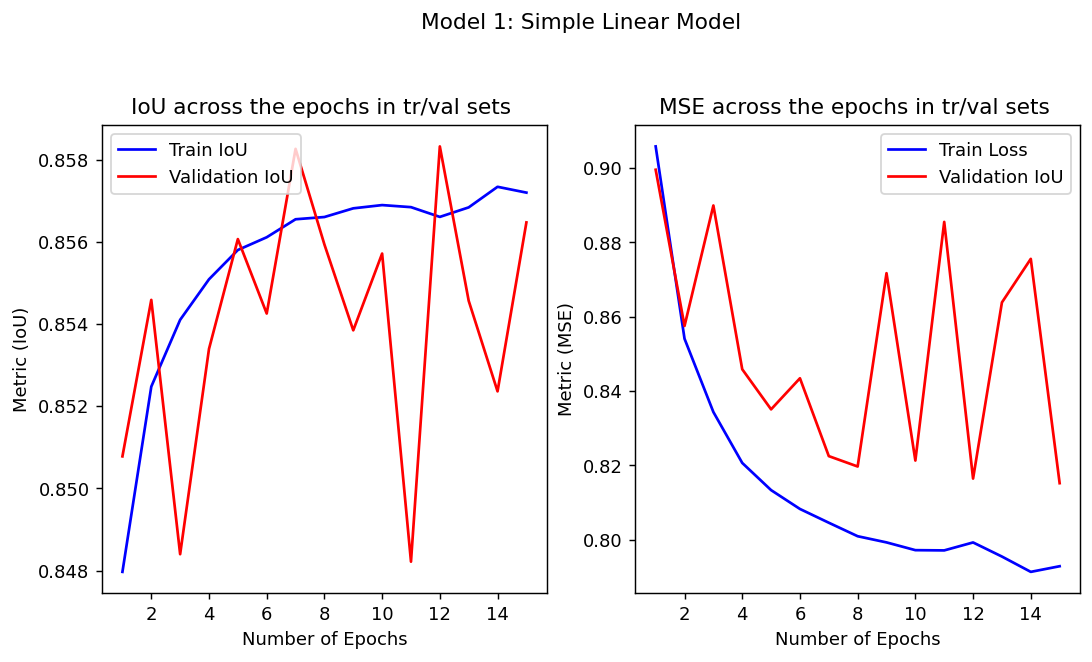

In [48]:
plot_metrics(df_0, "Model 1: Simple Linear Model")

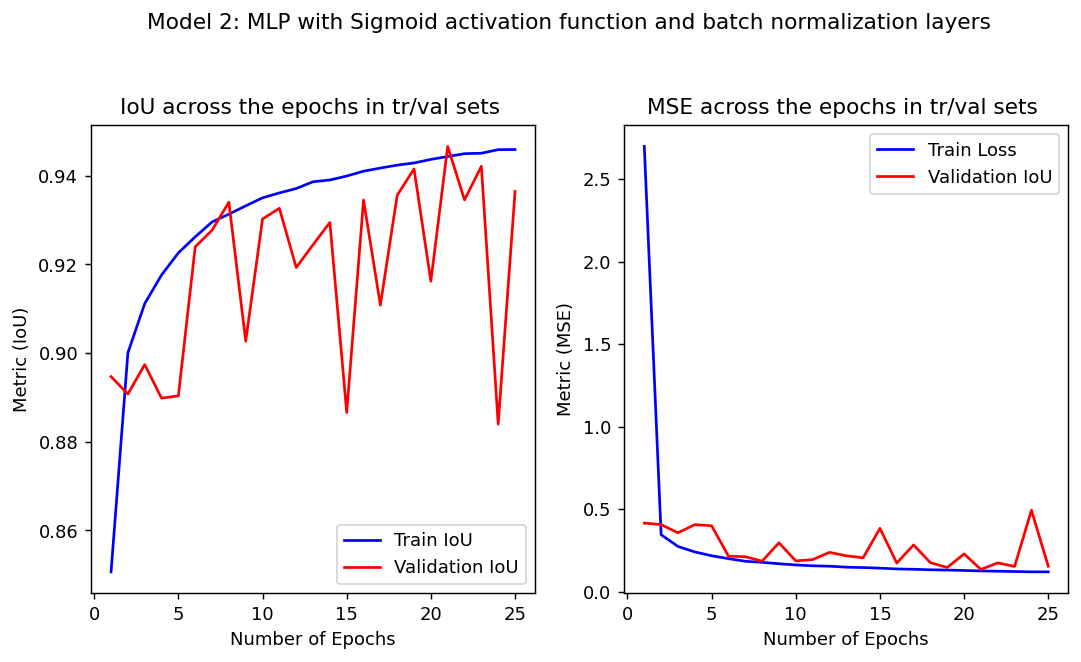

In [49]:
plot_metrics(df_1, "Model 2: MLP with Sigmoid activation function and batch normalization layers")

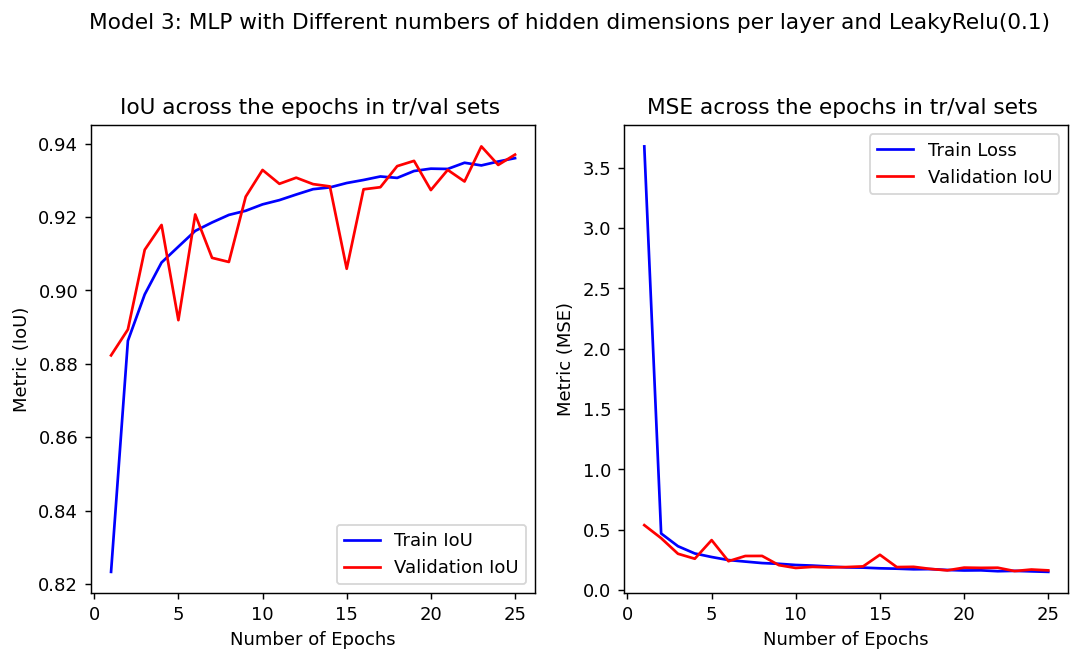

In [50]:
plot_metrics(df_2, "Model 3: MLP with Different numbers of hidden dimensions per layer and LeakyRelu(0.1)")

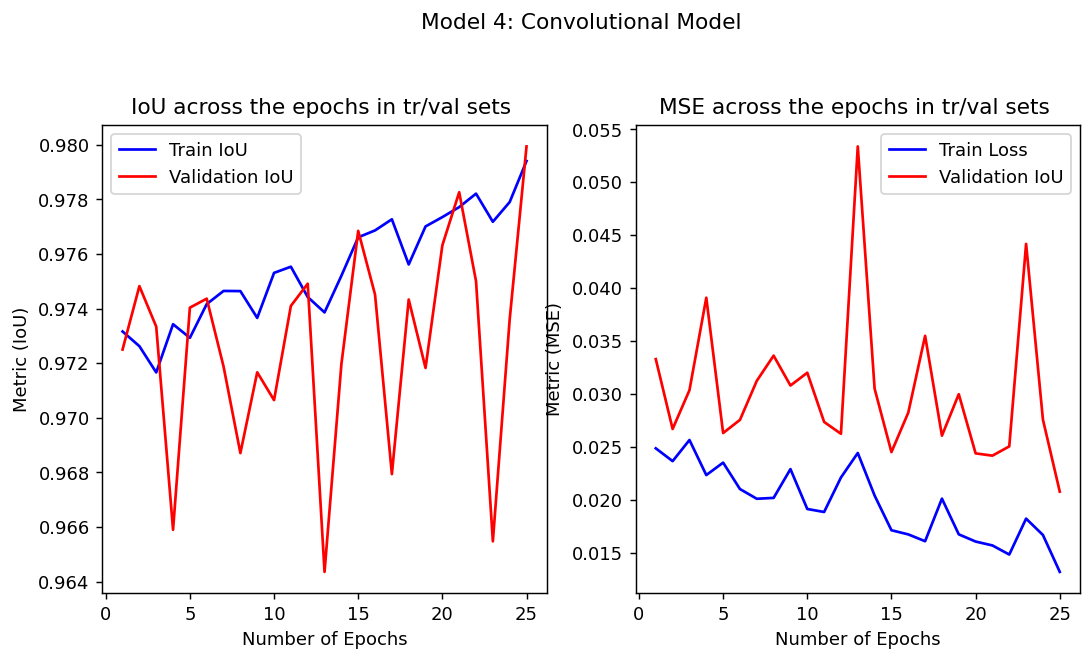

In [51]:
plot_metrics(df_3, "Model 4: Convolutional Model")

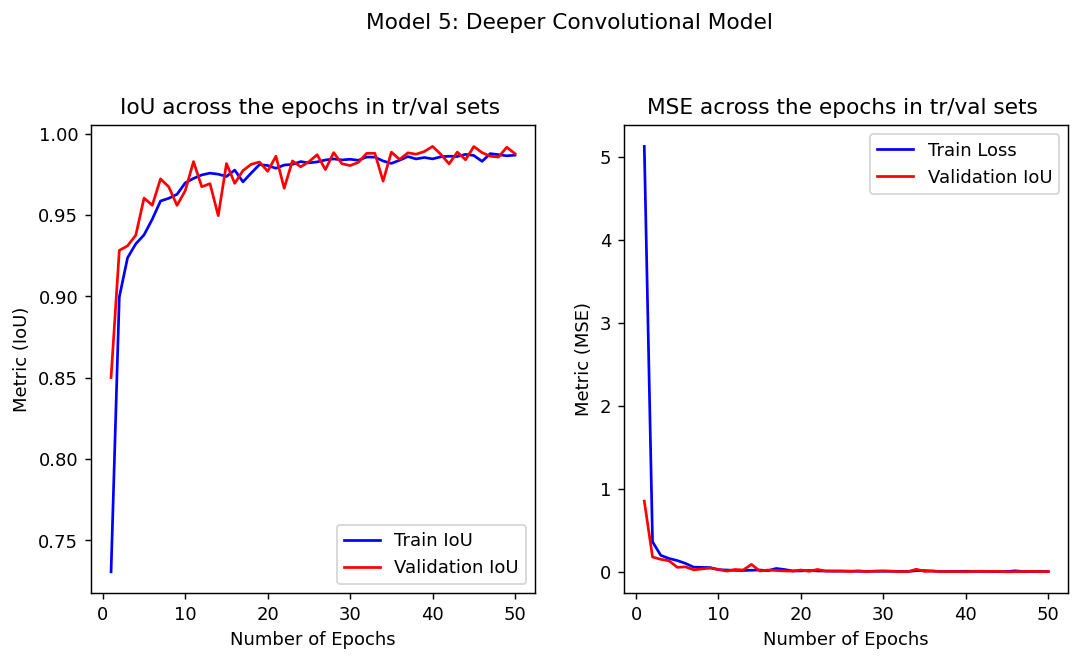

In [52]:
plot_metrics(df_4, "Model 5: Deeper Convolutional Model")

The best model is the last CNN model. We can see it is the one that reaches the best results and also it´s the one its values are the most stable ones.

Let´s evaluate the the result in test

In [85]:
test_iou = 0.0
pred_test_final = []
test_iou_final = []
labels_test_final = []
images_test = []
for data_test, target_test in test_loader:
    output_test = torch.round(model_conf_4(data_test))
    iou_test_batch = iou_metric(output_test, target_test).item() 
    test_iou += iou_test_batch
    test_iou_final += [iou_test_batch]
    pred_test_final += [output_test]
    labels_test_final += [target_test]
    images_test += [data_test]
pred_test_final = torch.cat(pred_test_final, dim=0)
target_test_final = torch.cat(labels_test_final, dim=0)
images_test = torch.cat(images_test, dim=0)

test_iou /= len(test_loader)   
test_iou

0.9987999351260761

We can see that the model is not overfitting, as the results in test are similar than in val and train

And let´s visualize some predictions of our model compare to the original ones

In [100]:
# Let´s choose some images to plot:

labels_test_final = labels_test_final[0] 

torch.Size([10000, 4])

In [121]:
pred_test_final = pred_test_final.detach().numpy()  # change the format as well

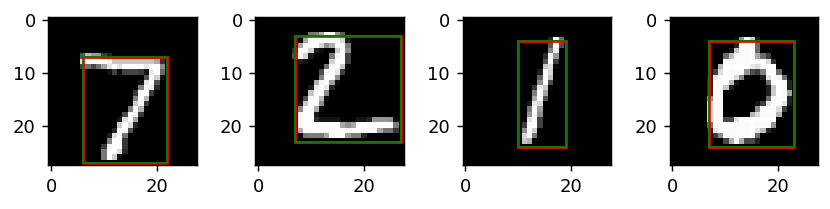

In [132]:
fig, ax = plt.subplots(1,4)  # let´s plot 4 numbers

fig.tight_layout(pad=0.2)  # to increase the space between the numbers

for i in range(0,4):
    
    ax[i].imshow(images_test[i].permute(1, 2, 0), cmap='gray')

    x1, x2, y1, y2 = labels_test_final[i]
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax[i].add_patch(rect)
    
    x1_, x2_, y1_, y2_ = pred_test_final[i]
    rect_ = patches.Rectangle((x1_, y1_), x2_ - x1_, y2_ - y1_, linewidth=1, edgecolor='g', facecolor='none')

    # Add the patch to the Axes
    ax[i].add_patch(rect_)    
    